# Data Mining principles BASIC REGRESSION MODEL - Josefina Bollini

In [4]:
# Packages 
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from scipy.stats.stats import pearsonr  
import matplotlib as mpl
import matplotlib.pyplot as plt

# Load and Explore the data
csv_name = "GermanCredit.csv"
datain = pd.read_csv(f"./{csv_name}")
#datain.info()

#How many iterations fo the regression? 
n_iterations = 1000
#How many variables to include as predictors?
n_predictors = 19

In [5]:
# Calculate correlation as a way to see which are the predictors to choose
# Choosing the highest correlated to keep the model simple
def corr_and_vars(datain,response,n_predictors):
    corr_matrix = datain.corr()
    corr_vals = abs(corr_matrix[response].sort_values(ascending=False))[1:(n_predictors+1)]
    Predictors = list(dict(corr_vals).keys())
    Response = [response]
    return Predictors,Response

Predictors,Response = corr_and_vars(datain,"Amount",19)
datain_reduced = datain[Predictors + Response]
#datain_reduced.info()
datain_reduced.describe()

,Duration,Job.Management.SelfEmp.HighlyQualified,Purpose.UsedCar,Property.Unknown,Housing.ForFree,Purpose.Other,Personal.Male.Single,CreditHistory.NoCredit.AllPaid,CheckingAccountStatus.0.to.200,CreditHistory.Delay,SavingsAccountBonds.Unknown,Purpose.Business,EmploymentDuration.Unemployed,OtherDebtorsGuarantors.CoApplicant,Property.CarOther,EmploymentDuration.4.to.7,ForeignWorker,OtherInstallmentPlans.Bank,Personal.Male.Divorced.Seperated,Amount
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.00000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000
mean,20.903000,0.148000,0.103000,0.154000,0.108000,0.01200,0.54800,0.040000,0.269000,0.088000,0.18300,0.097000,0.062000,0.041000,0.332000,0.174000,0.963000,0.13900,0.050000,3271.258000
std,12.058814,0.355278,0.304111,0.361129,0.310536,0.10894,0.49794,0.196057,0.443662,0.283437,0.38686,0.296106,0.241276,0.198389,0.471167,0.379299,0.188856,0.34612,0.218054,2822.736876
min,4.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,250.000000
25%,12.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,1365.500000
50%,18.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,2319.500000
75%,24.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.00000,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.00000,0.000000,3972.250000
max,72.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.00000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,18424.000000


<AxesSubplot:xlabel='Duration', ylabel='Amount'>

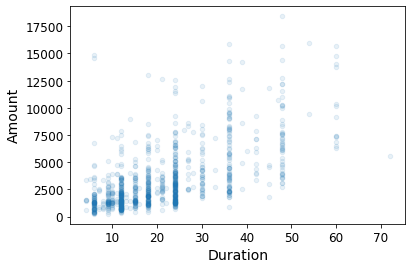

In [6]:
# Zooming in the Duration :
# To plot pretty figures
%matplotlib inline

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

datain_reduced.plot(kind="scatter", x="Duration", y="Amount",alpha=0.1)

### Functions to select the train/test and run the regression

In [7]:
# This function calculates R2, MAE, MSE and RMSE
def metrics_calc(FX,Fy,suffix,iteration,lin_reg):
        y_pred = lin_reg.predict(FX)

        MAE = metrics.mean_absolute_error(Fy, y_pred)
        MSE = metrics.mean_squared_error(Fy, y_pred)
        rmse = np.sqrt(metrics.mean_squared_error(Fy, y_pred))
        
        if suffix == 'test':
            # Calculate R2 as the squared correlation between actual and predicted 
            y_pred_arr = np.array(y_pred[:,0].tolist())
            Fy_arr = np.array(Fy[:,0].tolist())
            score = pearsonr(Fy_arr,y_pred_arr)[0]**2
        else:
            score = lin_reg.score(FX,Fy)
            
        cols = ['R2_'+str(suffix),'MAE_'+str(suffix),'MSE_'+str(suffix),'RMSE_'+str(suffix)]
        data = [score,MAE,MSE,rmse]
        
        metrics_df = pd.DataFrame(columns=cols)
        metrics_df.loc[iteration] = data

        return metrics_df
    

In [8]:
# This function splits the observtions in train and test and run the linear Regression
def StratSample_Regression(datain_full,Predictors,Response,Strat_based,
                           max_groups = 6,
                           n_splits=1,
                           test_size=0.368,
                           iteration = 1):

    datain = datain_full.copy()
    datain[Strat_based + "_bins"] = np.ceil(datain[Strat_based] / 10)
    datain[Strat_based + "_bins"].where(datain[Strat_based + "_bins"] < max_groups, max_groups, inplace=True)
        
    split = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size)
    
    for train_index, test_index in split.split(datain, datain[Strat_based + "_bins"]):
        strat_train_set = datain.loc[train_index]
        strat_test_set = datain.loc[test_index]

    # Prepare for regression
    X = np.array(strat_train_set[Predictors])
    y = np.array(strat_train_set[Response].copy())
    
    X_test = np.array(strat_test_set[Predictors])
    y_test = np.array(strat_test_set[Response].copy())
                             
    # Model Training: 
    lin_reg = LinearRegression()
    lin_reg.fit(X, y)
    coeffs = lin_reg.coef_[0].tolist()
    reg_intercept = [lin_reg.intercept_[0]]
    coeffs = reg_intercept + coeffs
  
    metrics_train_df = metrics_calc(X,y,'train',iteration,lin_reg)
    metrics_test_df = metrics_calc(X_test,y_test,'test',iteration,lin_reg)
    metrics_df = metrics_test_df.merge(metrics_train_df,left_index=True, right_index=True)
                                      
    coef_df = pd.DataFrame(columns= ['Intercept'] + Predictors)
    coef_df.loc[iteration] = coeffs

    results_df = metrics_df.merge(coef_df,left_index=True, right_index=True)

    return results_df

### Run the previous function n_iterations times

In [9]:
for i in range(1,n_iterations+1):             
    this_results_df = StratSample_Regression(datain_reduced,Predictors,Response,"Duration",iteration = i) 
    
    if i ==1:
        final_results = this_results_df
    else:
        final_results = pd.concat([final_results,this_results_df])

In [10]:
final_results

,R2_test,MAE_test,MSE_test,RMSE_test,R2_train,MAE_train,MSE_train,RMSE_train,Intercept,Duration,...,CreditHistory.Delay,SavingsAccountBonds.Unknown,Purpose.Business,EmploymentDuration.Unemployed,OtherDebtorsGuarantors.CoApplicant,Property.CarOther,EmploymentDuration.4.to.7,ForeignWorker,OtherInstallmentPlans.Bank,Personal.Male.Divorced.Seperated
1,0.476017,1435.085398,3.996866e+06,1999.216449,0.498948,1417.723662,4.095074e+06,2023.628891,666.534745,119.545930,...,782.082945,501.180627,-80.368487,481.885469,573.606026,61.779167,185.508978,-1002.971370,-19.591496,625.973657
2,0.425115,1536.391083,5.056876e+06,2248.749911,0.524319,1337.151735,3.560645e+06,1886.967039,765.804688,113.206294,...,209.232139,475.598002,-240.340126,106.553192,778.926233,22.927241,-43.036698,-875.295987,-203.742158,718.901210
3,0.527144,1408.986282,4.280564e+06,2068.952471,0.471851,1365.386079,3.960704e+06,1990.151834,-313.780958,114.884716,...,61.812783,421.143408,182.305519,118.794099,827.251046,136.576309,213.575655,257.870136,-209.593800,384.114759
4,0.386840,1573.017766,5.655508e+06,2378.131267,0.552721,1285.181853,3.237684e+06,1799.356558,427.041115,115.624096,...,787.477306,343.288227,-54.351511,-205.643545,359.654260,63.835153,392.252509,-590.118201,199.853182,112.305220
5,0.567116,1380.578128,4.039259e+06,2009.790855,0.445786,1384.581972,4.120174e+06,2029.821249,715.811461,115.834129,...,446.453133,295.721617,-162.461129,205.921147,-31.074165,33.497854,303.484078,-851.736831,-109.124517,385.205175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,0.407632,1576.031524,5.205733e+06,2281.607521,0.545844,1293.392881,3.407987e+06,1846.073433,173.594481,125.315117,...,404.009130,454.055226,246.591475,-425.462666,1085.197791,145.538955,169.634439,-548.940284,60.933768,730.680882
997,0.480120,1356.319846,3.929342e+06,1982.256868,0.494030,1428.776051,4.157938e+06,2039.102217,683.670578,117.671862,...,264.141145,478.770274,120.661559,373.123560,392.207764,-1.012755,272.661701,-892.399345,-348.109633,268.916925
998,0.467752,1465.380254,4.489691e+06,2118.889078,0.496587,1341.241693,3.891678e+06,1972.733593,-234.769740,113.556439,...,287.843545,508.824404,498.514868,35.819755,537.900018,8.030698,280.633131,-18.148486,-115.769462,267.106561
999,0.485675,1317.391407,3.492500e+06,1868.823102,0.492122,1477.702739,4.410657e+06,2100.156350,388.631518,127.493771,...,169.503862,472.745711,244.981147,277.014806,404.822590,120.090274,145.345946,-597.739261,-390.100763,240.805548


###  Plot the distribution of the 3 of the coefficients 

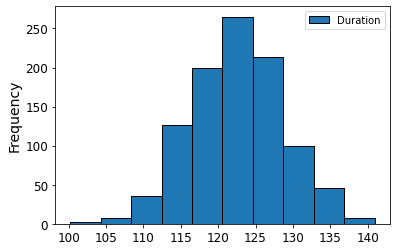

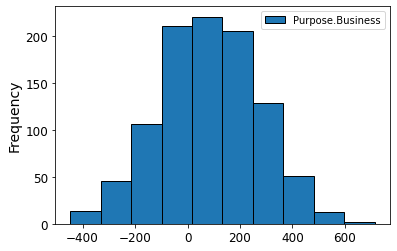

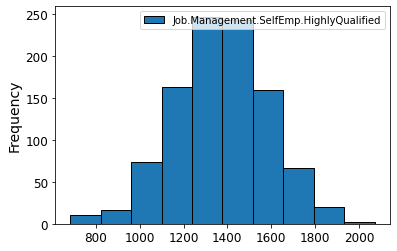

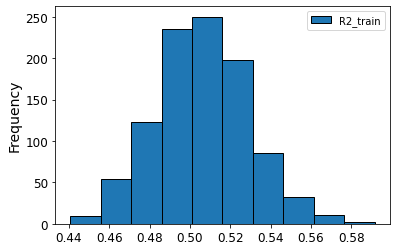

In [11]:
import matplotlib.pyplot as plt
def plotdata(var):
    final_results[var].plot(kind='hist',bins=10,edgecolor='black',legend =var)
    plt.show()
    
plotdata('Duration')
plotdata('Purpose.Business')
plotdata('Job.Management.SelfEmp.HighlyQualified')
plotdata('R2_train')

### Calculate % Fall of R2 and plot its distribution

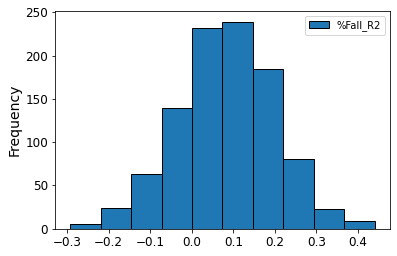

,R2_train,R2_test,%Fall_R2
count,1000.000000,1000.000000,1000.000000
mean,0.506217,0.461157,0.083832
std,0.022848,0.039065,0.117129
min,0.440652,0.328987,-0.292600
25%,0.490479,0.435748,0.007941
50%,0.505634,0.462439,0.085205
75%,0.520993,0.486913,0.163093
max,0.591663,0.569586,0.440323


In [12]:
final_results['%Fall_R2'] = (final_results['R2_train']-final_results['R2_test'])/final_results['R2_train']
plotdata('%Fall_R2')
final_results.describe()[['R2_train','R2_test','%Fall_R2']]

When using the model fitted for a training set to make predictions on the test set our R2 decrease on average in a 8%. This is expected since we are making predictions on data that was not part of our training set. there is no exact rule on how much fail is to much, in this case the R2 for the training set it was not good enough to say the model is good, so loosing 8% when tested does not make it a good model either. 


### Mean and Standard Deviation of each coefficient

In [13]:
full_coeff_list = ["Intercept"] + Predictors
mean_std = final_results.describe().T[['mean','std']]
coeffs_mean_std = mean_std.loc[full_coeff_list]
coeffs_mean_std

,mean,std
Intercept,258.545435,262.633060
Duration,122.482732,6.091449
Job.Management.SelfEmp.HighlyQualified,1370.251454,213.658595
Purpose.UsedCar,1280.023851,201.575421
Property.Unknown,728.033242,340.347249
Housing.ForFree,-235.570237,402.763540
Purpose.Other,2309.451139,1147.289942
Personal.Male.Single,298.910948,99.325361
CreditHistory.NoCredit.AllPaid,1227.600384,332.981083
CheckingAccountStatus.0.to.200,362.276163,121.084508


### Calculating the Results for the entire sample


In [14]:
# Prepare for regression
X = np.array(datain_reduced.drop(Response, axis=1))
y = np.array(datain_reduced[Response].copy())
    
# Model
lin_reg = LinearRegression()
lin_reg.fit(X, y)
coeffs_full = lin_reg.coef_[0].tolist()
reg_intercept = [lin_reg.intercept_[0]]
coeffs_full = reg_intercept + coeffs_full 

metrics_full_df = metrics_calc(X,y,'full',1,lin_reg)
coef_full_df = pd.DataFrame(columns= full_coeff_list)
coef_full_df.loc[1] = coeffs_full

results_full_df = metrics_full_df.merge(coef_full_df,left_index=True, right_index=True).T.rename(columns = {1:'full'})
Compare_with_full_coeffs = pd.merge(results_full_df.loc[full_coeff_list],mean_std.loc[full_coeff_list],left_index=True, right_index=True)
Compare_with_full_coeffs['%Diff_coeffs'] = abs((Compare_with_full_coeffs['full']-Compare_with_full_coeffs['mean'])/Compare_with_full_coeffs['full'])*100
Compare_with_full_coeffs.sort_values(by = ['%Diff_coeffs'])


,full,mean,std,%Diff_coeffs
CheckingAccountStatus.0.to.200,362.391778,362.276163,121.084508,0.031904
OtherInstallmentPlans.Bank,-131.280685,-131.228826,150.823761,0.039502
Personal.Male.Single,299.362973,298.910948,99.325361,0.150995
Purpose.UsedCar,1277.595997,1280.023851,201.575421,0.190033
Duration,122.761600,122.482732,6.091449,0.227163
Purpose.Other,2296.163651,2309.451139,1147.289942,0.578682
EmploymentDuration.4.to.7,219.426714,220.861355,130.494044,0.653813
Housing.ForFree,-233.909259,-235.570237,402.763540,0.710095
Job.Management.SelfEmp.HighlyQualified,1382.665287,1370.251454,213.658595,0.897819
Personal.Male.Divorced.Seperated,576.887526,570.820424,265.457142,1.051696


When comparing the mean of the coefficints when selecting 1000 different samples from the data with the results obtained when running one regression with all the information avialable as training data, we can see that the percentage difference goes from 0.17% to 10%: there is no big difference in the results for not training the model using the full sample but we gain on teh poibility of validating the results with the test set. 

## Confidence Intervals

In [15]:
# Confidence intervals:
import scipy.stats as st
import statistics

def ConfidenceIntervals(datain,var):
    data2 = sorted(datain[var].tolist(), key = lambda x:float(x))
    Lower_Bound = np.percentile(data2, 2.5)
    Upper_Bound = np.percentile(data2, 97.5)
    Width = Upper_Bound - (Lower_Bound*(0.632**0.5))
    data = [Lower_Bound,Upper_Bound,Width]
    CItable.loc[var] = data


cols = ['Lower_Bound','Upper_Bound','Width']
CItable = pd.DataFrame(columns=cols)

for pred in full_coeff_list:
    ConfidenceIntervals(final_results,pred)
    


In [16]:
#Confidence Intervals on the full sample coefficients:
X_with_intercept = datain_reduced.copy()
X_with_intercept['Intercept'] = 1 
X = np.array(datain_reduced.drop(Response, axis=1))
X_with_intercept = np.array(X_with_intercept.drop(Response, axis=1))
y = np.array(datain_reduced[Response].copy())

N = len(X)
p = len(Predictors) + 1 

# we need to calculate the standard errors
y_hat = lin_reg.predict(X)
residuals = y - y_hat
residual_sum_of_squares = residuals.T @ residuals
sigma_squared_hat = residual_sum_of_squares[0, 0] / (N - p)
var_beta_hat = np.linalg.inv(X_with_intercept.T @ X_with_intercept) * sigma_squared_hat

                                  
            

In [17]:
cols = ['Estimate','Std_Error','Lower_Bound_full','Upper_Bound_full','Width_full']
CItable_full = pd.DataFrame(columns=cols)

for coef in range(0,len(full_coeff_list)):
    standard_error = var_beta_hat[coef,coef] ** 0.5    
    Estimate = coef_full_df.T.reset_index().loc[coef].values[1]
    Lower_Bound = Estimate -(1.96*standard_error) 
    Upper_Bound = Estimate+(1.96*standard_error)
    Width = Upper_Bound - Lower_Bound
    
    data = [Estimate,standard_error,Lower_Bound,Upper_Bound,Width]
    Coeff_name = full_coeff_list[coef]
    CItable_full.loc[Coeff_name] = data


    
CItable_full = CItable_full.merge(CItable,left_index=True, right_index=True)
CItable_full['CI_Status'] = np.where(CItable_full['Width'] > CItable_full['Width_full'],"Mean CI is broader", "Full CI is broader")

In [18]:
CItable_full.groupby('CI_Status').count()['Estimate']/len(CItable_full)*100

CI_Status
Full CI is broader    60.0
Mean CI is broader    40.0
Name: Estimate, dtype: float64

When comparing the mean of the coefficients when selecting 1000 different samples from the data with the results obtained when running one regression with all the information available for training the model, 40% of the 20 coefficients (predictors+Intercept) estimated show a broader Confidence Interval when using the full sample. 
As the number of iterations is higher - random samples from the data are taking , the percentages remain the same. 1000 iterations is already high enough to get results and the means will be approximately normally distributed. 

